# Event detection algorithms

In [29]:
from pathlib import Path

from nilmtk.dataset import DataSet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [30]:
from event_detection.plotting.events import plot_events, plot_statistics
from event_detection.detectors import HartDetector, GLRDetector, GLRVoteDetector, GOFDetector, GOFVoteDetector

In [31]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,5) 

In [32]:
data_path = Path().home().joinpath('Documents', 'DataSets')
dataset_name = "REDD"

## Import REDD dataset

In [33]:
data = DataSet(data_path.joinpath(dataset_name, f"{dataset_name.lower()}.h5"))

### Select period and house

In [34]:
house_n = 1
data.set_window("2011-04-18 00:00", "2011-04-19 00:00")
house = data.buildings[house_n].elec
mains = house.mains()
submeters = house.submeters()

### Load aggregated consumption

In [39]:
good_sections = mains.good_sections()
mains_gen = mains.load(physical_quantity='power', ac_type='apparent', sample_period=1, sections=good_sections)
mains_df = pd.DataFrame()
for section in mains_gen:
    mains_df = pd.concat([mains_df, section])

/home/epalacio/Documents/Code/event-detection-premises/.venv/lib/python3.9/site-packages/nilmtk/metergroup.py:987: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warnings.warn(
/home/epalacio/Documents/Code/event-detection-premises/.venv/lib/python3.9/site-packages/nilmtk/base/results.py:80: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self._data = pd.concat([self._data, row], verify_integrity=True, sort=False)
/home/epalacio/Documents/Code/event-detection-premises/.venv/lib/python3.9/site-packages/nilmtk/base/results.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries i

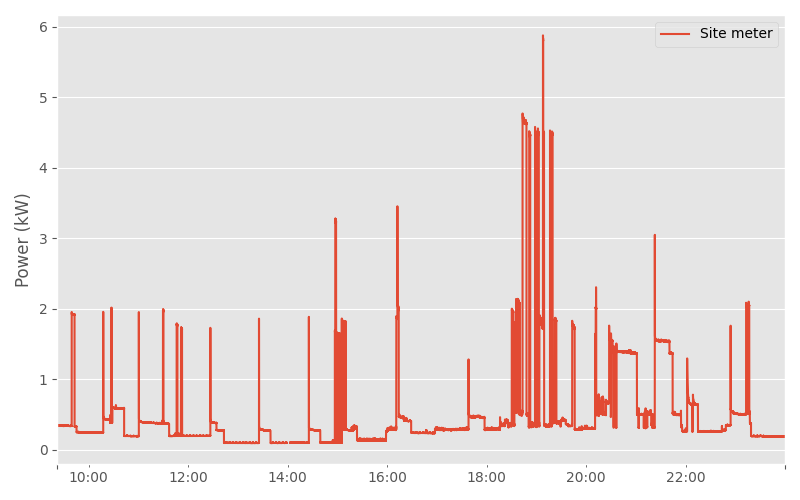

In [40]:
fig = plt.figure()
mains.plot(unit='kW', physical_quantity='power', ac_type='apparent', sample_period=1, kind="sum")
plt.tight_layout()

### Load individual appliamnces consumption

In [41]:
apps = []
for submeter in submeters.meters:
    main_type = submeter.label()
    meter = submeter.load(physical_quantity='power', ac_type='active', sample_period=3, sections=good_sections)
    app_df = pd.DataFrame()
    for section in meter:
        app_df = pd.concat([app_df, section])
    apps.append((main_type, [app_df]))

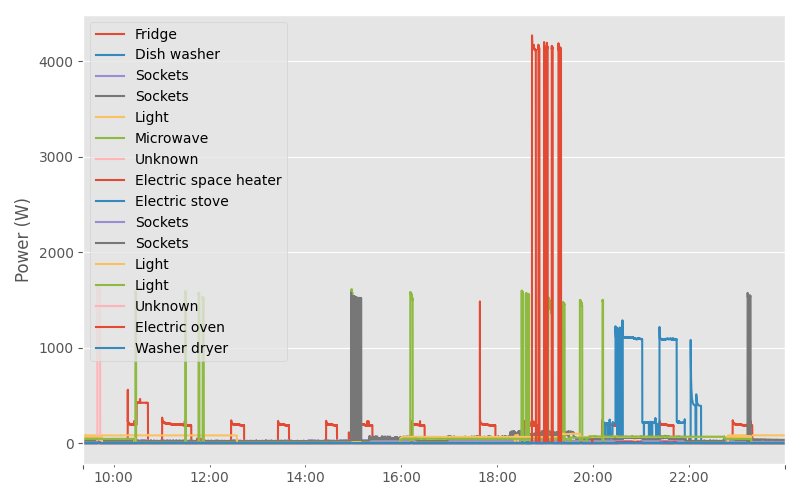

In [42]:
fig = plt.figure()
submeters.plot(physical_quantity='power', ac_type='active', sample_period=3)
plt.tight_layout()

## Test event detection algorithms

In [43]:
min_power = 50

### Fill NaN and apply median filter to aggregated signal

In [44]:
mains_df.fillna(method='bfill', inplace=True)

/tmp/ipykernel_40152/2366555438.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mains_df.fillna(method='bfill', inplace=True)


In [45]:
from scipy.ndimage import median_filter
mains_df[('power', 'filtered')] = median_filter(mains_df[[('power', 'apparent')]].values, size=5)

### Hart Dectector

In [46]:
hart_detector = HartDetector(event_threshold=min_power, state_threshold=min_power, min_n_samples=2)
hart_events = hart_detector.offline_events(pd.DataFrame(mains_df[("power", "filtered")]), detailed=False)

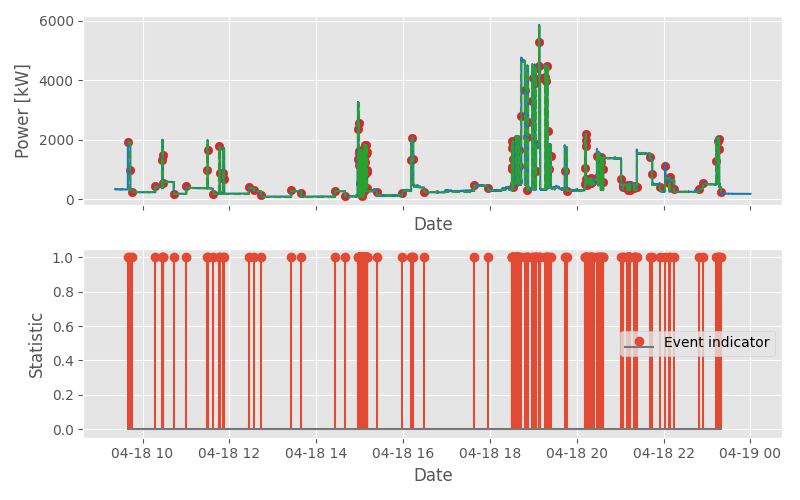

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(8 ,5), sharex=True)
plot_events(mains_df[("power", "filtered")], hart_events.transitions, hart_events.pos_states, ax[0])
plot_statistics(hart_events.statistic_1, ax[1])
plt.tight_layout()

### GLR (Generalised Likelihood Ratio)

In [48]:
glr_detector = GLRDetector(event_threshold=min_power, stat_window=(30,30), stat_threshold=150, range_std=(1.0,10.0))
glr_events = glr_detector.offline_events(pd.DataFrame(mains_df[("power", "filtered")]))

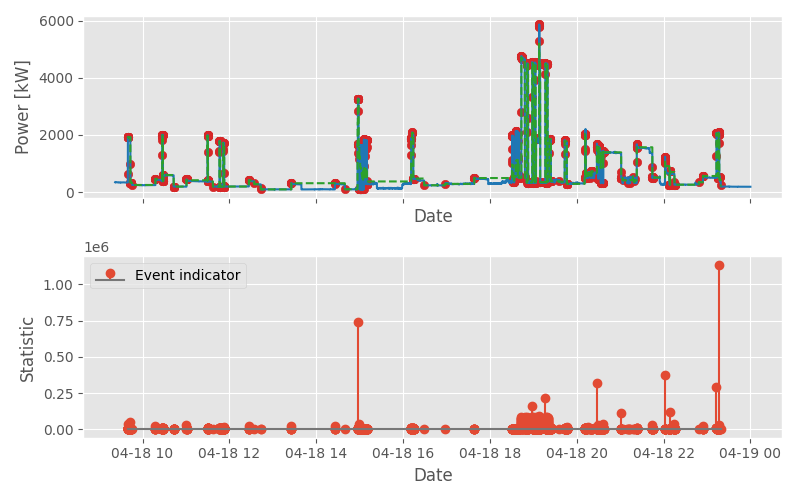

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(8 ,5), sharex=True)
plot_events(mains_df[("power", "filtered")], glr_events.transitions, glr_events.pos_states, ax[0])
plot_statistics(glr_events.statistic_1, ax[1])
plt.tight_layout()

### GLR with voting window

In [50]:
glr_vote_detector = GLRVoteDetector(event_threshold=min_power, stat_window=(5,5), event_window=10, vote_threshold=8, range_std=(1.0,1.0))
glr_vote_events = glr_vote_detector.offline_events(pd.DataFrame(mains_df[("power", "filtered")]))

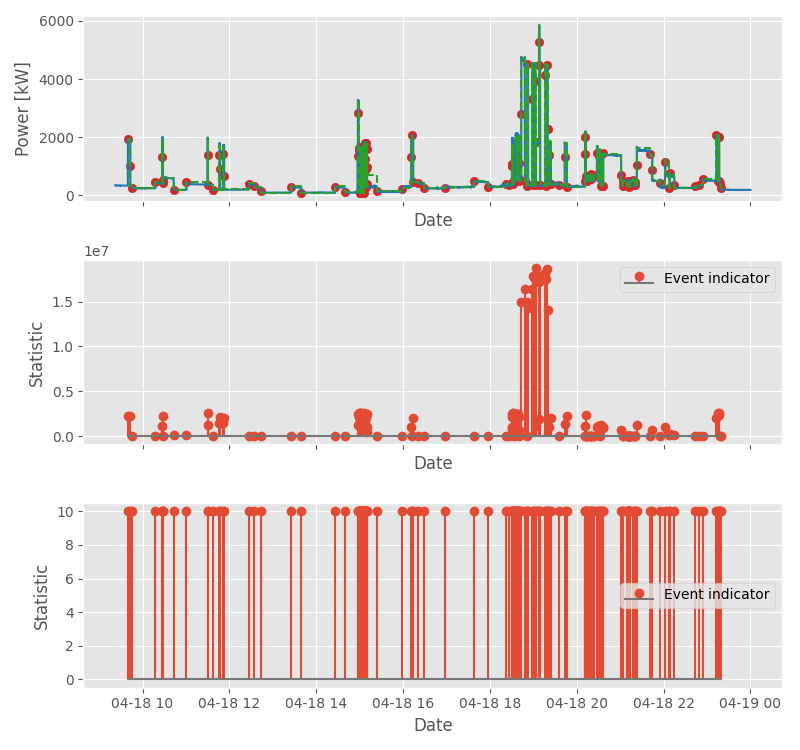

In [51]:
fig, ax = plt.subplots(3, 1, figsize=(8 ,7.5), sharex=True)
plot_events(mains_df[("power", "filtered")], glr_vote_events.transitions, glr_vote_events.pos_states, ax[0])
plot_statistics(glr_vote_events.statistic_1, ax[1])
plot_statistics(glr_vote_events.statistic_2, ax[2])
plt.tight_layout()

### GOF (Goodneess of Fit)

In [52]:
gof_detector = GOFDetector(event_threshold=min_power, stat_window=5, stat_threshold=0.01)
gof_events = gof_detector.offline_events(pd.DataFrame(mains_df[("power", "filtered")]))

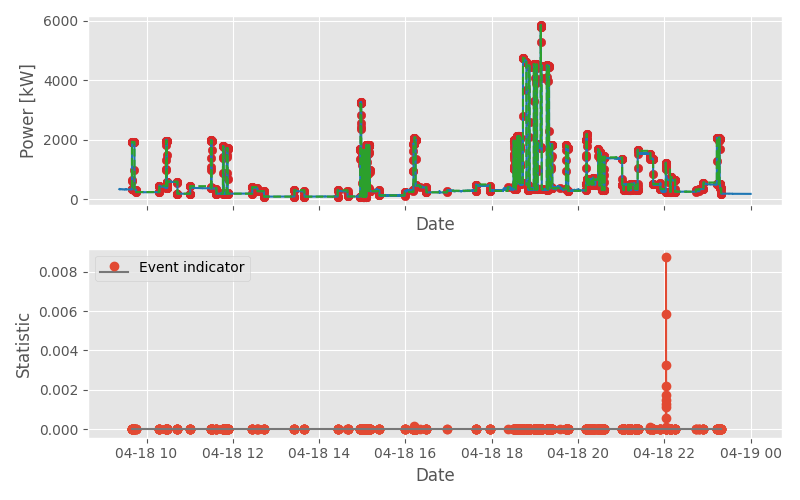

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(8 ,5), sharex=True)
plot_events(mains_df[("power", "filtered")], gof_events.transitions, gof_events.pos_states, ax[0])
plot_statistics(gof_events.statistic_1, ax[1])
plt.tight_layout()

### GOF with voting window

In [54]:
gof_vote_detector = GOFVoteDetector(event_threshold=min_power, stat_window=5, event_window=10, vote_threshold=6)
gof_vote_events = gof_vote_detector.offline_events(pd.DataFrame(mains_df[("power", "filtered")]))

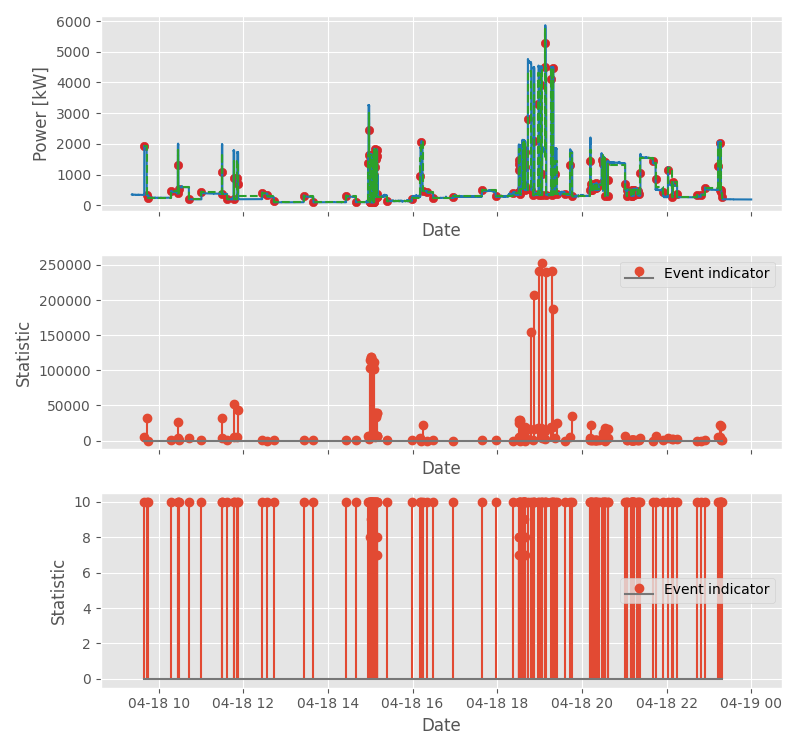

In [55]:
fig, ax = plt.subplots(3, 1, figsize=(8 ,7.5), sharex=True)
plot_events(mains_df[("power", "filtered")], gof_vote_events.transitions, gof_vote_events.pos_states, ax[0])
plot_statistics(gof_vote_events.statistic_1, ax[1])
plot_statistics(gof_vote_events.statistic_2, ax[2])
plt.tight_layout()